In [1]:
import numpy as np
import mne 
import scipy 
#%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [2]:
import cv2

In [4]:
sec=5
video_path='../../../ks.mp4'

In [5]:
def get_frame(video_path, sec):
    
    calc_timestamps = [0.0]
    cap = cv2.VideoCapture( video_path)
    timestamps = [cap.get(cv2.CAP_PROP_POS_MSEC)]
    fps = cap.get(cv2.CAP_PROP_FPS)

    while(cap.isOpened()):
        frame_exists, curr_frame = cap.read()
        #print(np.sum(curr_frame))
        #print('lol')
        if frame_exists:
            timestamps = cap.get(cv2.CAP_PROP_POS_MSEC)
            calc_timestamps.append(calc_timestamps[-1] + 1000/fps)
            ts=calc_timestamps[-1] + 1000/fps
            
            if sec<(ts/1000):
                print(ts/1000)
                #print('ghl;', np.sum(curr_frame))
                plt.figure()
                plt.imshow(curr_frame)
                break

In [6]:
#fps = vcap.get(cv2.CV_CAP_PROP_FPS)

def get_frmae(video_path, second):
    '''function probably is incorrect but it seemed to wors as get_frame'''
    
    #start=20
    
    vcap = cv2.VideoCapture( video_path)
    ret, frame = vcap.read()
    #fps = vcap.get(cv2.CAP_PROP_FPS)
    #times 1/24
    
    frame_num=int(second*24)

    for i in range(frame_num):
        #vcap = cv2.VideoCapture('../../../ks.mp4')
        ret, frame = vcap.read()
    #plt.close()
    print(second)
    print(i)
    plt.figure()
    plt.imshow(frame)



In [7]:
raw_data=mne.io.read_raw_brainvision('../../ks/NeoRec_2022-12-06_19-45-11.vhdr', preload=True)

Extracting parameters from ../../ks/NeoRec_2022-12-06_19-45-11.vhdr...
Setting channel info structure...
Reading 0 ... 1865409  =      0.000 ...   932.705 secs...


In [8]:
events,ids=mne.events_from_annotations(raw_data)

Used Annotations descriptions: ['1/Event', 'New Segment/']


In [9]:
raw_data.crop(events[-1,0]/raw_data.info['sfreq'], None)

<RawBrainVision | NeoRec_2022-12-06_19-45-11.eeg, 15 x 1862819 (931.4 s), ~213.2 MB, data loaded>

Using matplotlib as 2D backend.


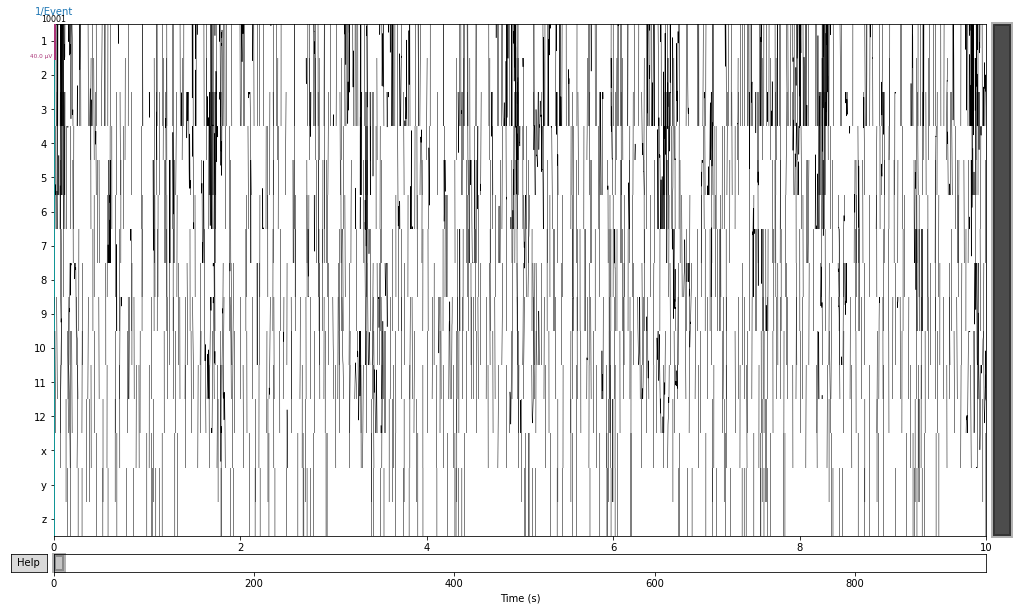

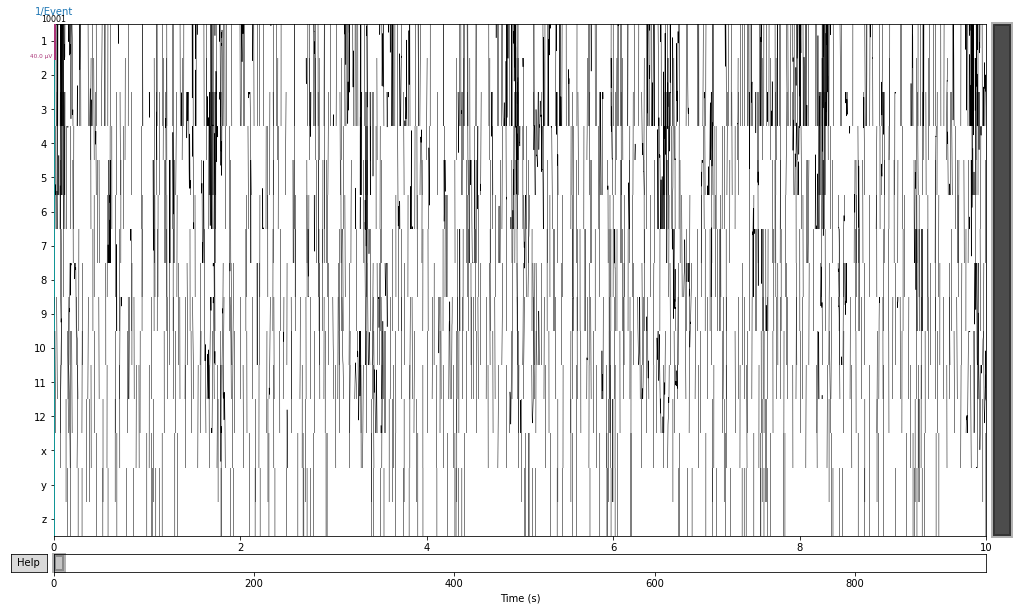

In [10]:
raw_data.plot(events)

In [11]:
raw_data.ch_names

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'x', 'y', 'z']

In [12]:
#Extract only accelerometry data
raw_data_acc=raw_data.copy().drop_channels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])

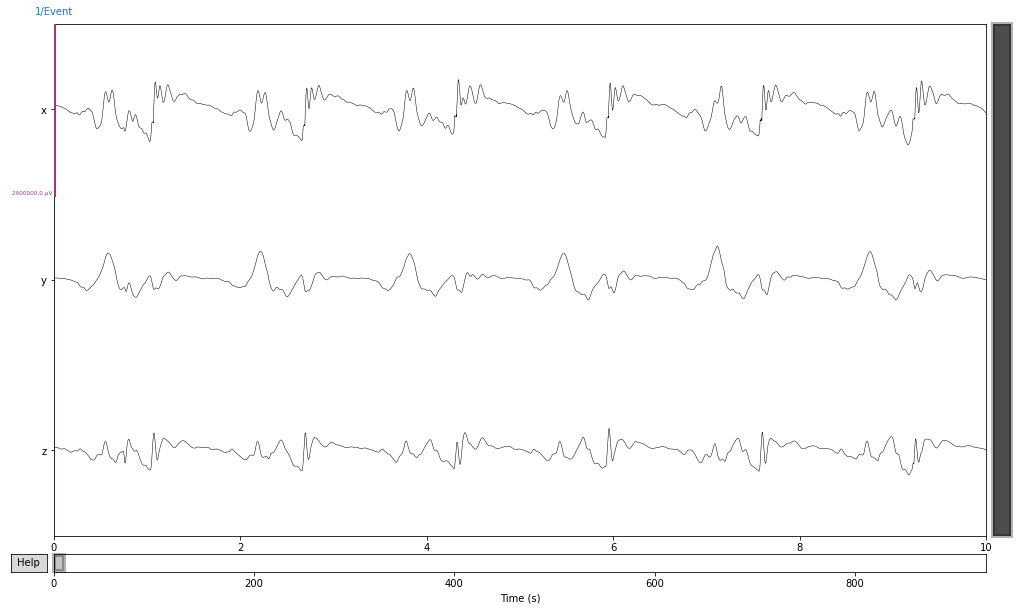

In [13]:
raw_data_acc.plot(scalings={'eeg':0.1e1})
plt.show()

In [14]:
#taking the matrix of accelerometry data
xyz=raw_data_acc.get_data()


In [15]:
#we working with y axes becaise it is the best one
y_data=xyz[1,:]

In [17]:

start=0
period=3300
end=start+period


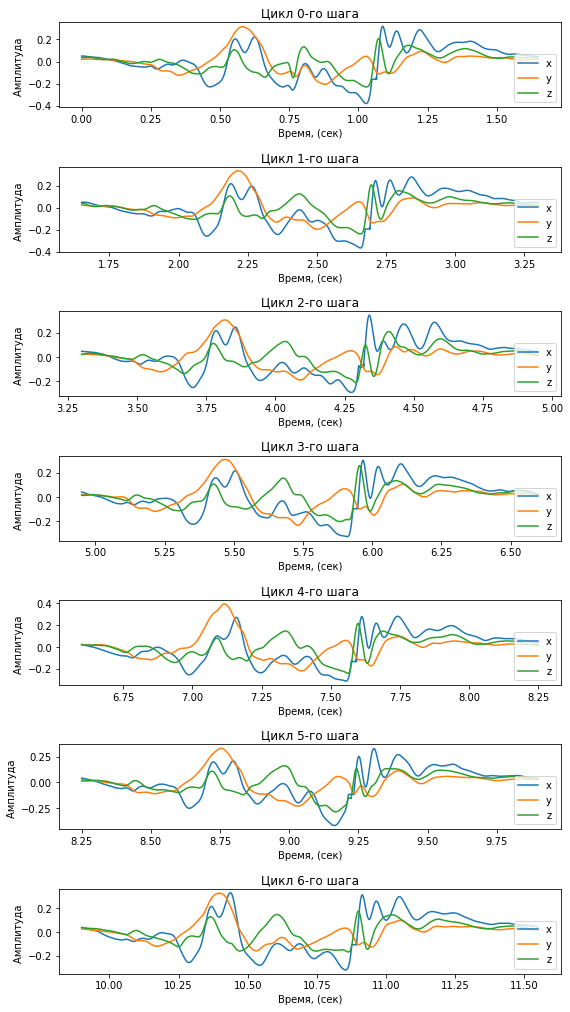

In [18]:
'''
plot several cycles to check how acc data looks like
'''

plt.close()

cycles=7

fig,ax=plt.subplots(cycles,1, figsize=(9,2.5*cycles))
plt.subplots_adjust(hspace=0.7)

for i in range(cycles):
    ax[i].plot( np.arange(start+period*i,end+period*i)/raw_data.info['sfreq'],  xyz[:,start+period*i:end+period*i].T  , label=['x', 'y', 'z'])
    ax[i].set_title('Цикл '+str(i)+'-го шага')
    ax[i].set_xlabel('Время, (сек)')
    ax[i].set_ylabel('Амплитуда ')
    ax[i].legend(loc='lower right')


In [19]:
def find_peaks(array_, koef=1.1, max_flg=False):

    mean_=np.mean(array_)
    std_=np.std(array_)

    max_=mean_+koef*std_
    min_=mean_-koef*std_

    max_array_=[max_]*len(array_)
    min_array_=[min_]*len(array_)

    inds=np.where(array_>max_)[0]
    
    if max_flg:
        return inds, max_
    
    else:
        return inds
    
    
def find_peaks_min(array_, koef=1.1, max_flg=False):

    mean_=np.mean(array_)
    std_=np.std(array_)

    max_=mean_+koef*std_
    min_=mean_-koef*std_

    max_array_=[max_]*len(array_)
    min_array_=[min_]*len(array_)

    inds=np.where(array_<min_)[0]
    
    if max_flg:
        return inds, min_
    
    else:
        return inds
    
def reduce_peaks(marks_array_inds,  threhold, with_log=False,):
    
    new_marks_array_inds=[marks_array_inds[0]]
    for i in range(1,len(marks_array_inds)):
        if marks_array_inds[i]-new_marks_array_inds[-1]<threhold:
            if with_log:
                print(i)
        else:
            new_marks_array_inds.append(marks_array_inds[i])

    return new_marks_array_inds


In [20]:
#extracting peak of y acceletimetry 
inds=find_peaks(y_data,1.7)

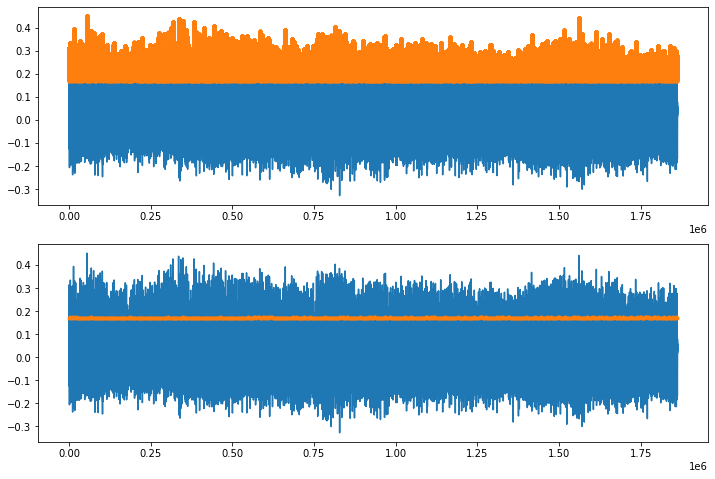

In [21]:
plt.close()
fig,ax=plt.subplots(2,1, figsize=(12,8))
ax[0].plot(y_data)
ax[0].plot(inds,y_data[inds], '.')


new_peaks=reduce_peaks(inds, 2000) #reducing its number
ax[1].plot(y_data)
ax[1].plot(new_peaks,y_data[new_peaks], '.')

In [22]:
%matplotlib qt5

In [23]:
events_max=np.array(new_peaks)+raw_data.first_samp

In [24]:

zeros=[0]*len(events_max)
marks=[1]*len(events_max)

ones=np.vstack([events_max,zeros,marks]).T


zeros=[0]*len(events_max)
marks=[2]*len(events_max)
twos=events_max+600

twos=np.vstack([twos,zeros,marks]).T




In [25]:
ones

array([[   3655,       0,       1],
       [   6910,       0,       1],
       [  10110,       0,       1],
       ...,
       [1857254,       0,       1],
       [1860446,       0,       1],
       [1863477,       0,       1]])

In [26]:
len(ones)
len(twos)

574

In [27]:
events=np.vstack([ones,twos])
events=events[events[:, 0].argsort()]
events[:,0]=events[:,0]#+raw_data.first_samp

In [28]:
raw_data.first_samp

2591

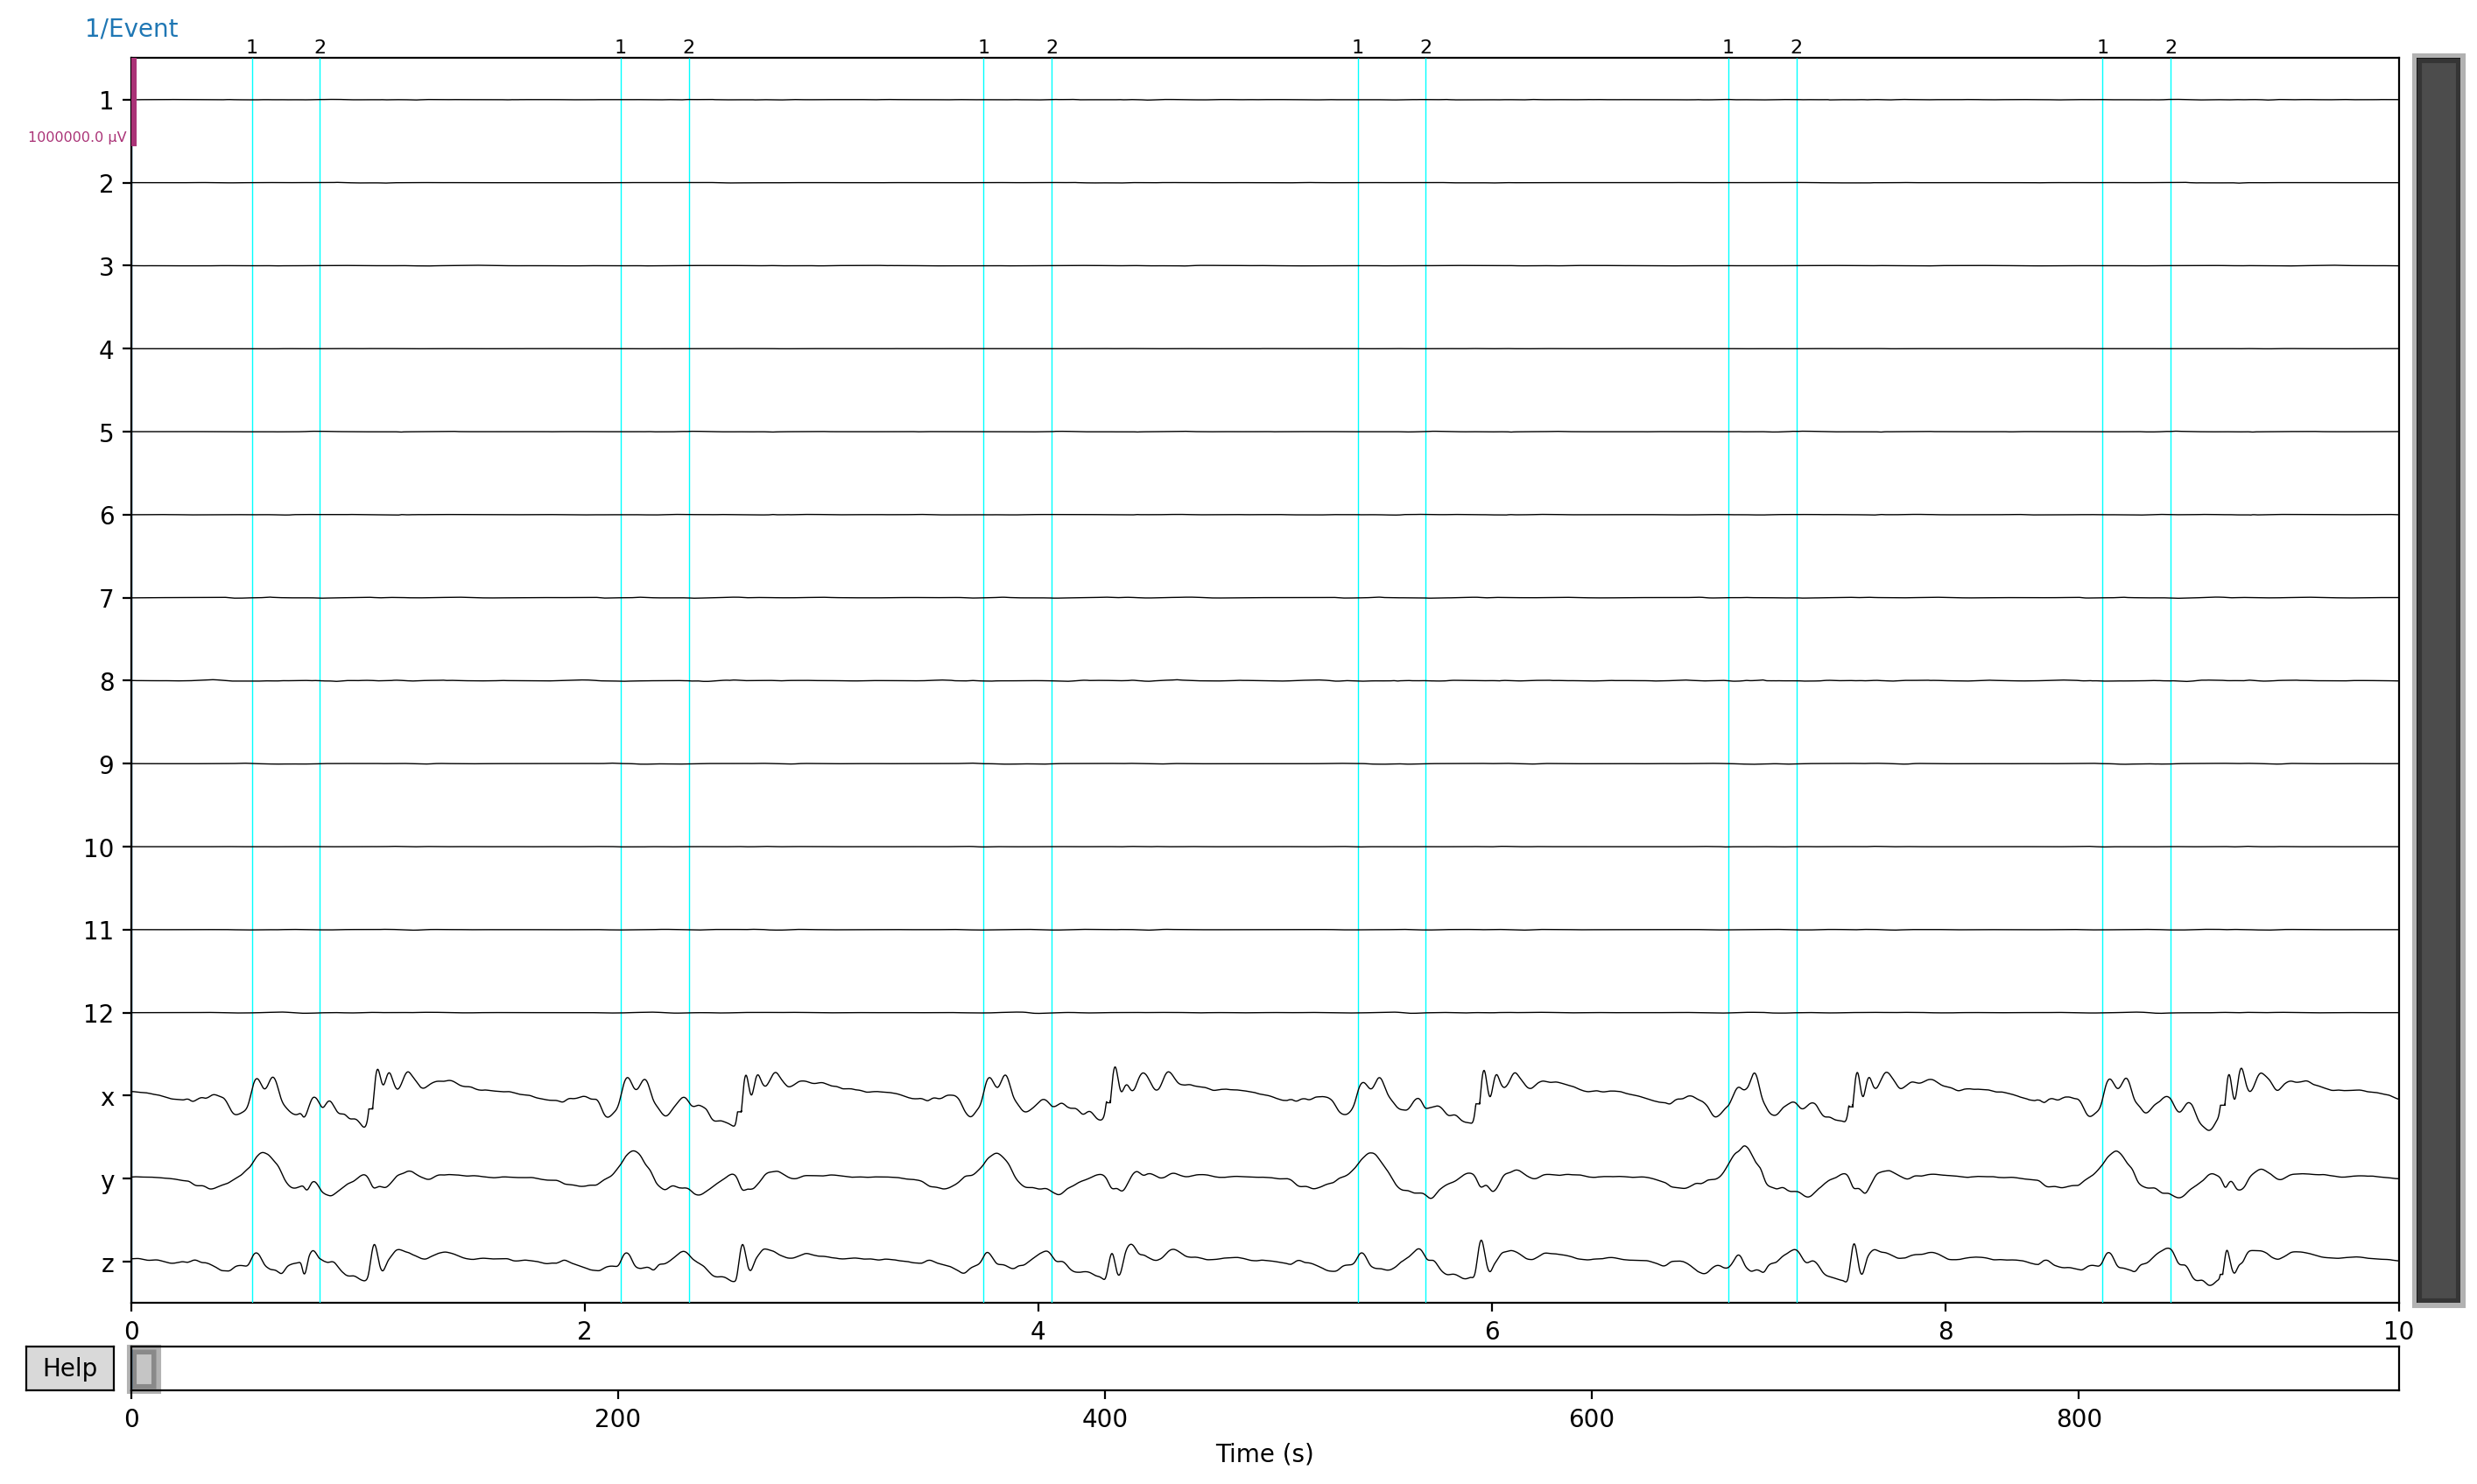

In [29]:
raw_data.plot(events,scalings={'eeg':5e-1})

In [31]:
for ind in np.arange(1,40,5):
    
    s=( (ones[ind,0]-raw_data.first_samp)/raw_data.info['sfreq'])
    print(s)
    get_frame(video_path,s)
    
    
    s=( (twos[ind,0]-raw_data.first_samp)/raw_data.info['sfreq'])
    print(s)
    get_frame(video_path,s)
    
    plt.figure()
    print((ones[ind,0])-2000-raw_data.first_samp)
    plt.plot(y_data[(ones[ind,0])-2000-raw_data.first_samp:(ones[ind,0])+2000-raw_data.first_samp] )
    plt.scatter(2001,y_data[ (ones[:,0])[ind]-raw_data.first_samp])


2.1595
2.16
2.4595
2.48
2319
10.346
10.36
10.646
10.68
18692
18.7085
18.72
19.0085
19.04
35417
27.331
27.36
27.631
27.64
52662
35.9795
36.0
36.2795
36.28
69959
44.5105
44.52
44.8105
44.84
87021
52.691
52.72
52.991
53.0
103382
61.066


/var/folders/2m/6g8qzjcd00n9j42dqh2ndj780000gn/T/ipykernel_26702/1222250725.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


61.08
61.366
61.4
120132
Channels marked as bad: none


In [32]:
raw_data_emg=raw_data.copy().drop_channels(['x','y','z'])


SAMPLING_FREQUENCY = raw_data_emg.info['sfreq']
CHANNEL_NUMBER = len(raw_data_emg.ch_names)
BANDPASS_LIMITS = (200, 500)

In [33]:
raw_hil = raw_data_emg.copy().filter(BANDPASS_LIMITS[0], BANDPASS_LIMITS[1]).apply_hilbert(envelope=True).filter(0, 20)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 500.00 Hz
- Upper transition bandwidth: 125.00 Hz (-6 dB cutoff frequency: 562.50 Hz)
- Filter length: 133 samples (0.067 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter l

In [34]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib

def conf_matrix_plot(categs, matrix_bef, size=3,perc_flg=True):
    
    group_percentages = ["{0:.2%}".format(value) for value in
                     matrix_bef.flatten()/np.sum(matrix_bef)]
    
    if perc_flg:
        labels = np.asarray(group_percentages).reshape(size,size)
    else:
        labels =matrix_bef
    sns.set_style("darkgrid", {"axes.facecolor": "0.9"})
    matplotlib.rcParams.update({'font.size': 32})
    fig1, ax1 = plt.subplots(figsize=[10,8])
    sns.heatmap(matrix_bef,cmap='Blues',xticklabels=categs,yticklabels=categs,annot=labels, fmt='',ax=ax1)

    #matplotlib.rcParams.update({'font.size': defa})

In [35]:
epochs=mne.Epochs(raw_hil, events=events, tmin=-0.5, tmax=0.0, 
                        preload=True, 
                        baseline=None).apply_hilbert(envelope=True)

Not setting metadata
Not setting metadata
1148 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1148 events and 1001 original time points ...
0 bad epochs dropped


In [36]:
epochs

Number of events,1148
Events,1: 5742: 574
Time range,-0.500 – 0.000 sec
Baseline,off


In [37]:
def get_features_labels(epochs):
    X=[]
    for i in range(epochs._data.shape[0]):
        channel_names = np.arange(CHANNEL_NUMBER).astype(str).tolist()
        channel_types = ['emg']*CHANNEL_NUMBER
        info = mne.create_info(channel_names, SAMPLING_FREQUENCY, channel_types)
        raw = mne.io.RawArray(epochs._data[i], info, verbose=False)
        raw.filter(BANDPASS_LIMITS[0], BANDPASS_LIMITS[1], picks=['emg'], n_jobs=4)
        x__=[]
        # Mean absolute value
        for channel in raw.get_data():
            x__.append(channel.mean())
        # Matematical expactation
        for channel in raw.get_data():
            x__.append(channel.std())
        # Variance
        for channel in raw.get_data():
            x__.append(channel.var())
        # Waveform length
        for channel in raw.get_data():
            x__.append(np.sum(np.diff(channel, n=1)))
        # Number pf peaks
        for channel in raw.get_data():
            x__.append(len(find_peaks(channel)))
        
        # Append PCA of epoch data
        pca = PCA(6)
        pv = pca.fit_transform(epochs._data[i])
                         
        X.append(x__)
    X = np.array(X).squeeze()
    y = epochs.events[:,-1].flatten()
    return X, y


In [38]:

X, y = get_features_labels(epochs)

print('X: ', X.shape)
print('Y: ', y.shape)
#classifier = SVC(C=0.8, kernel='rbf', probability=True)
# cross_val_score(classifier, X, y, cv=3)
#classifier.fit(X, y)
#classifier.score(X, y)

X:  (1148, 60)
Y:  (1148,)


In [39]:
classifier = SVC(C=0.8, kernel='rbf', probability=True)
#cross_val_score(classifier, X, y, cv=3)
classifier.fit(X, y)
classifier.score(X, y)

0.7717770034843205

In [40]:
tscv=TimeSeriesSplit(max_train_size=None, n_splits=4)

ac_list=[]

for train_index, test_index in tscv.split(X):
    print()
    #print("TRAIN:", train_index, "TEST:", test_index) 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("TRAIN:", X_train.shape,y_train.shape )
    print("TEST:", X_test.shape, y_test.shape) 
    
    
    classifier.fit(X_train, y_train)
    ac=classifier.score(X_test, y_test)
    print('Accuracy:', ac)
    
    ac_list.append(ac)
    
    #matrix=confusion_matrix(y_test,preds)
    
    preds=classifier.predict(X_test)
    matrix=confusion_matrix(y_test,preds)
    #plt.
    
    #conf_matrix_plot(categs, matrix)
    #conf_matrix_plot(categs, matrix , perc_flg=False)
    
    categs=['Фаза-1','Фаза-2']
    conf_matrix_plot(categs, matrix,2)
    conf_matrix_plot(categs, matrix ,2, perc_flg=False)
    


TRAIN: (232, 60) (232,)
TEST: (229, 60) (229,)
Accuracy: 0.7467248908296943

TRAIN: (461, 60) (461,)
TEST: (229, 60) (229,)
Accuracy: 0.6681222707423581

TRAIN: (690, 60) (690,)
TEST: (229, 60) (229,)
Accuracy: 0.6812227074235808

TRAIN: (919, 60) (919,)
TEST: (229, 60) (229,)
Accuracy: 0.7467248908296943


In [41]:
ac_list

[0.7467248908296943,
 0.6681222707423581,
 0.6812227074235808,
 0.7467248908296943]

In [43]:
plt.figure()
plt.plot(np.arange(4),ac_list, 'g.-')
plt.xlabel('Тестируемая выборка')
plt.ylabel('Точность предсказания')
plt.xticks(np.arange(4), ['1-ая четверть', '2-ая четверть', '3-ая четверть','4-ая четверть'])
plt.grid()

In [44]:
zeros=[0]*len(events_max)
marks=[3]*len(events_max)

threes=np.vstack([np.array(events_max)+1500,zeros,marks]).T

#twos=np.vstack([events_max,zeros,marks]).T



In [45]:
events=np.vstack([ones,twos, threes]) 
events=events[events[:, 0].argsort()]
events[:,0]=events[:,0]#-raw_data.first_samp


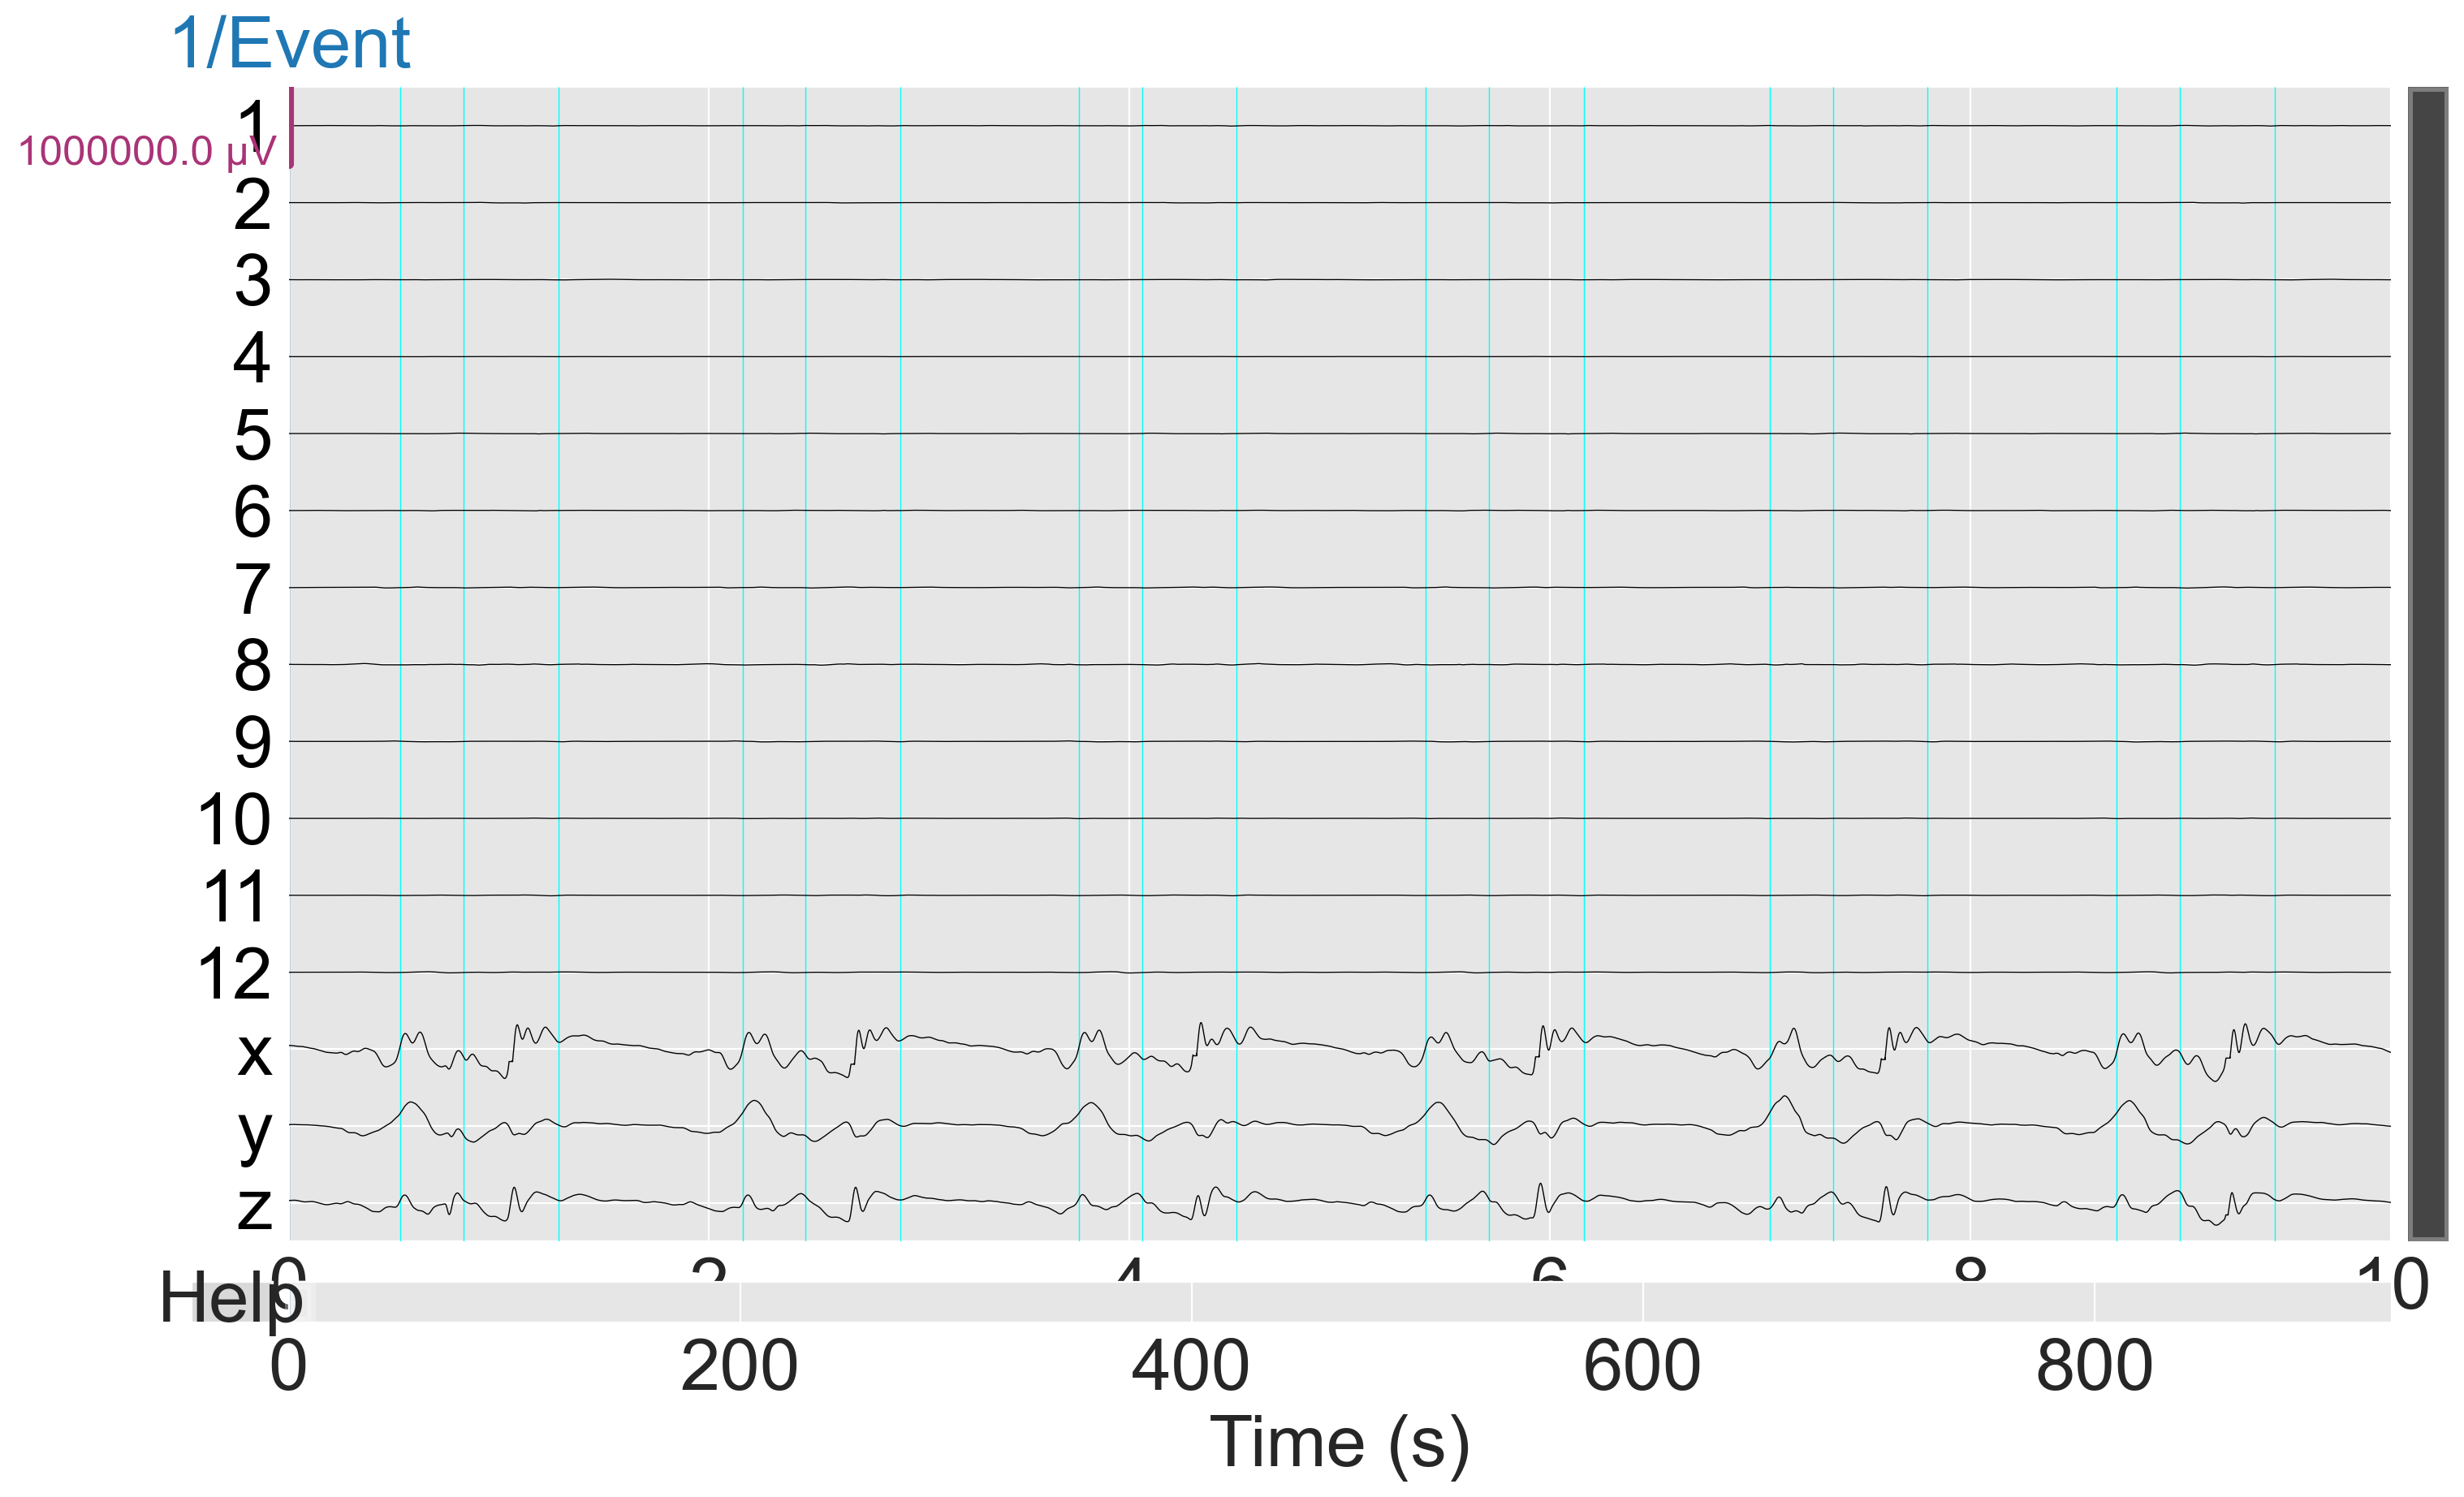

In [46]:
raw_data.plot(events,scalings={'eeg':5e-1})

In [47]:
zeros=[0]*len(events_max)
marks=[4]*len(events_max)

fores=np.vstack([np.array(events_max)+2000,zeros,marks]).T

#twos=np.vstack([events_max,zeros,marks]).T




In [48]:

events=np.vstack([ones,twos, threes, fores])
events=events[events[:, 0].argsort()]


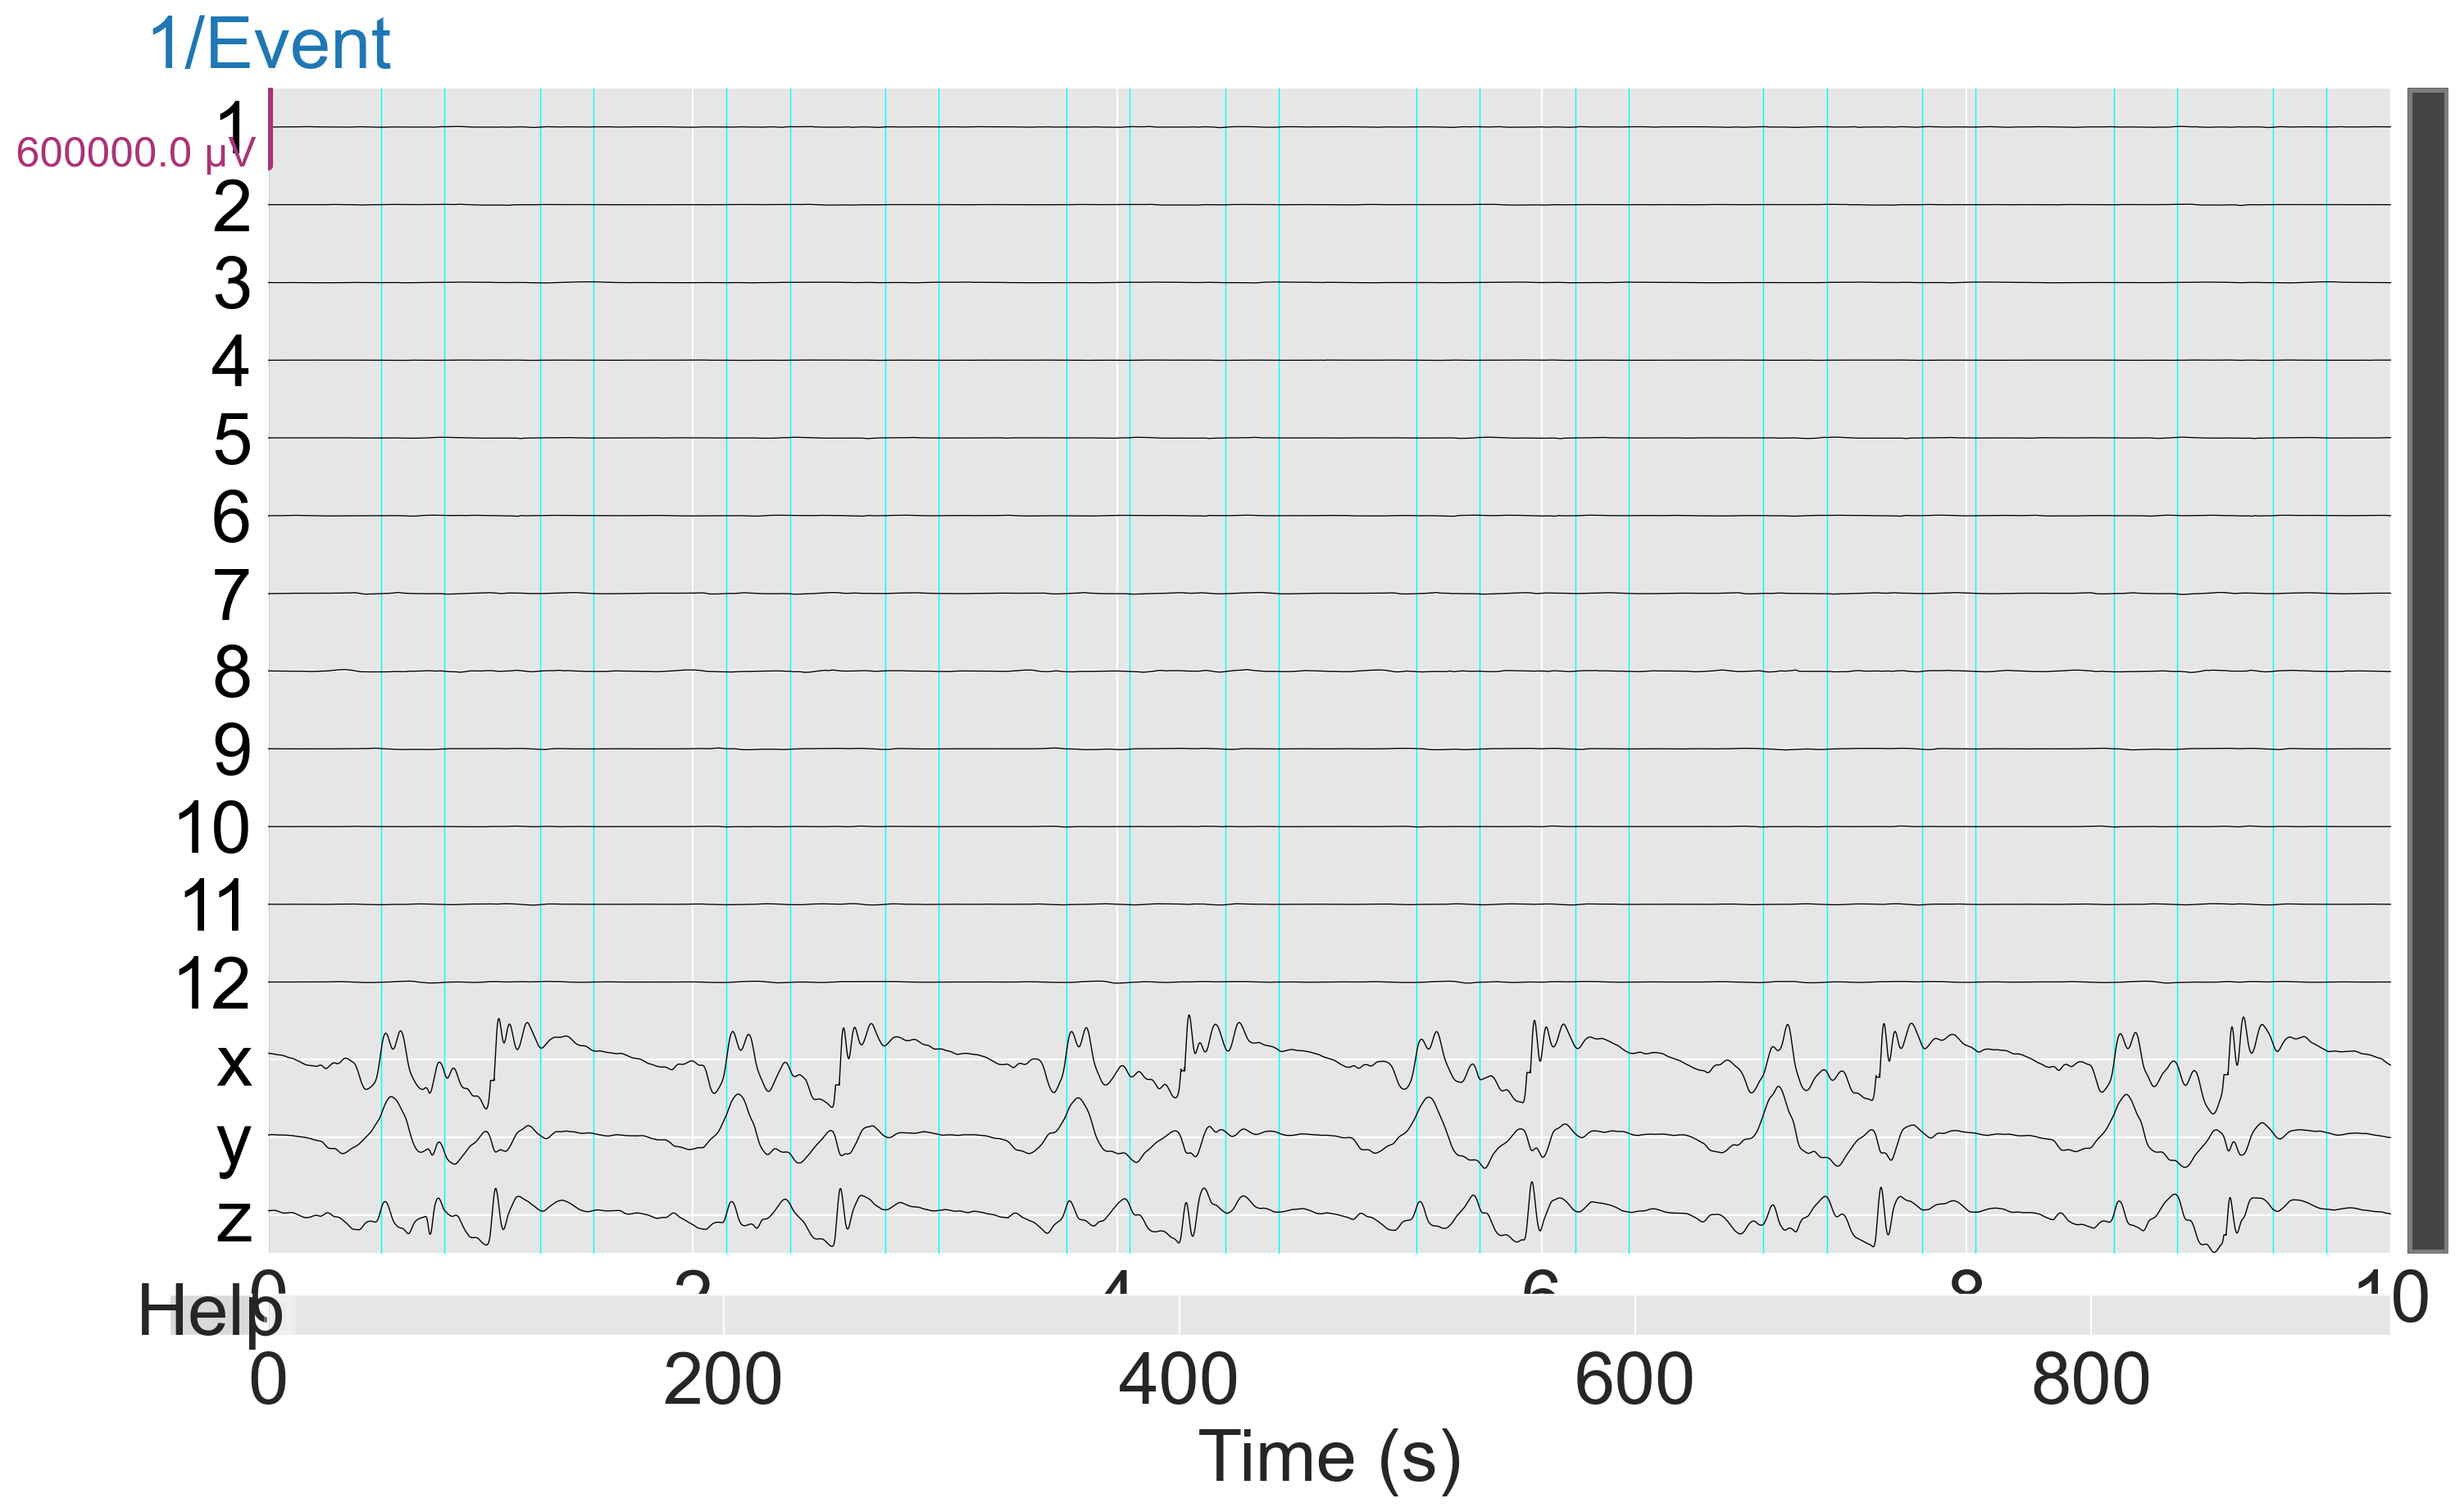

In [49]:
raw_data.plot(events,scalings={'eeg':0.3e0})

In [50]:
print((ones[:,0]/raw_data.info['sfreq'])[:1])#приземление на пятку
print((twos[:,0]/raw_data.info['sfreq'])[:1])#отрыв пятки 
print((threes[:,0]/raw_data.info['sfreq'])[:1])#опопа на пятку 
print((fores[:,0]/raw_data.info['sfreq'])[:1])

[1.8275]
[2.1275]
[2.5775]
[2.8275]


In [52]:
#fps = vcap.get(cv2.CV_CAP_PROP_FPS)

video_path='../../../ks.mp4'


In [54]:
ind=50

s=( (ones[ind,0]-raw_data.first_samp)/raw_data.info['sfreq'])
print(s)
get_frame(video_path,s)

s=( (twos[ind,0]-raw_data.first_samp)/raw_data.info['sfreq'])
print(s)
get_frame(video_path,s)


s=( (threes[ind,0]-raw_data.first_samp)/raw_data.info['sfreq'])
print(s)
get_frame(video_path,s)

s=( (fores[ind,0]-raw_data.first_samp)/raw_data.info['sfreq'])
print(s)
get_frame(video_path,s)


84.5625
84.6
84.8625
84.88
85.3125
85.32
85.5625
85.6
Channels marked as bad: none
Channels marked as bad: none


In [55]:
print(10)

10


In [56]:
epochs=mne.Epochs(raw_hil, events=events, tmin=-0.5, tmax=0.0, 
                        preload=True, 
                        baseline=None).apply_hilbert(envelope=True)

Not setting metadata
Not setting metadata
2296 matching events found
No baseline correction applied
0 projection items activated
Loading data for 2296 events and 1001 original time points ...
1 bad epochs dropped


In [57]:

X, y = get_features_labels(epochs)

print('X: ', X.shape)
print('Y: ', y.shape)
#classifier = SVC(C=0.8, kernel='rbf', probability=True)
# cross_val_score(classifier, X, y, cv=3)
#classifier.fit(X, y)
#classifier.score(X, y)

X:  (2295, 60)
Y:  (2295,)


In [58]:
classifier = SVC(C=0.8, kernel='rbf', probability=True)
#cross_val_score(classifier, X, y, cv=3)
classifier.fit(X, y)
classifier.score(X, y)

0.5843137254901961

In [59]:
print(10)

10


In [60]:
categs=['Фаза-1','Фаза-2', 'Фаза-3', 'Фаза-4']

In [61]:
tscv=TimeSeriesSplit(max_train_size=None, n_splits=4)
for train_index, test_index in tscv.split(X):
    print()
    #print("TRAIN:", train_index, "TEST:", test_index) 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("TRAIN:", X_train.shape,y_train.shape )
    print("TEST:", X_test.shape, y_test.shape) 
    
    
    classifier.fit(X_train, y_train)
    ac=classifier.score(X_test, y_test)
    print('Accuracy:', ac)
    
    
    preds=classifier.predict(X_test)
    matrix=confusion_matrix(y_test,preds)
    #plt.
    
    conf_matrix_plot(categs, matrix, size=4)
    conf_matrix_plot(categs, matrix , perc_flg=False,size=4)


TRAIN: (459, 60) (459,)
TEST: (459, 60) (459,)
Accuracy: 0.4749455337690632

TRAIN: (918, 60) (918,)
TEST: (459, 60) (459,)
Accuracy: 0.4923747276688453

TRAIN: (1377, 60) (1377,)
TEST: (459, 60) (459,)
Accuracy: 0.5076252723311547

TRAIN: (1836, 60) (1836,)
TEST: (459, 60) (459,)
Accuracy: 0.6143790849673203
